In [29]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


## Visualize the original image

image(BGR) shape(HWC): (1080, 1920, 3), dtype=uint8, size: 6220800
rgb_image(RGB) from image shape(HWC): (1080, 1920, 3), dtype: uint8, size： 6220800


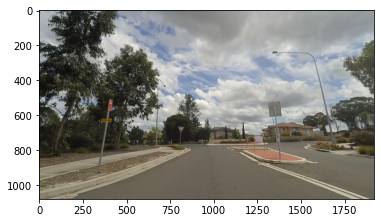

In [39]:
# The segmentation network expects images in BGR format
image = cv2.imread("image/empty_road_mapillary.jpg")
print(f"image(BGR) shape(HWC): {image.shape}, dtype={image.dtype}, size: {image.size}")

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(f"rgb_image(RGB) from image shape(HWC): {rgb_image.shape}, dtype: {rgb_image.dtype}, size： {rgb_image.size}")
image_h, image_w, _ = image.shape

plt.imshow(rgb_image)

## Visualize the result tensor returned by WasmEdge wasi-nn OpenVINO backend

data size: 1835008
resized_data: (1, 4, 512, 896), dtype: float32
segmentation_mask shape: (1, 512, 896), dtype: int64
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]]


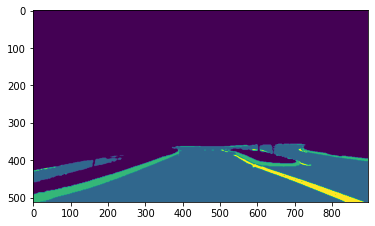

In [40]:
# parse the output file generated by wasi-nn
data = np.fromfile("tensor/wasinn-openvino-inference-output-1x4x512x896xf32.tensor", dtype=np.float32)
print(f"data size: {data.size}")
resized_data = np.resize(data, (1,4,512,896))
print(f"resized_data: {resized_data.shape}, dtype: {resized_data.dtype}")

# Prepare data for visualization
segmentation_mask = np.argmax(resized_data, axis=1)
print(f"segmentation_mask shape: {segmentation_mask.shape}, dtype: {segmentation_mask.dtype}")
print(f"{segmentation_mask[0]}")
plt.imshow(segmentation_mask[0])


## Prepare Data for Visualization

In [41]:
# The following function is from https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/utils/notebook_utils.py
def segmentation_map_to_image(
    result: np.ndarray, colormap: np.ndarray, remove_holes=False
) -> np.ndarray:
    """
    Convert network result of floating point numbers to an RGB image with
    integer values from 0-255 by applying a colormap.

    :param result: A single network result after converting to pixel values in H,W or 1,H,W shape.
    :param colormap: A numpy array of shape (num_classes, 3) with an RGB value per class.
    :param remove_holes: If True, remove holes in the segmentation result.
    :return: An RGB image where each pixel is an int8 value according to colormap.
    """
    if len(result.shape) != 2 and result.shape[0] != 1:
        raise ValueError(
            f"Expected result with shape (H,W) or (1,H,W), got result with shape {result.shape}"
        )

    if len(np.unique(result)) > colormap.shape[0]:
        raise ValueError(
            f"Expected max {colormap[0]} classes in result, got {len(np.unique(result))} "
            "different output values. Please make sure to convert the network output to "
            "pixel values before calling this function."
        )
    elif result.shape[0] == 1:
        result = result.squeeze(0)

    result = result.astype(np.uint8)

    contour_mode = cv2.RETR_EXTERNAL if remove_holes else cv2.RETR_TREE
    mask = np.zeros((result.shape[0], result.shape[1], 3), dtype=np.uint8)
    for label_index, color in enumerate(colormap):
        label_index_map = result == label_index
        label_index_map = label_index_map.astype(np.uint8) * 255
        contours, hierarchies = cv2.findContours(
            label_index_map, contour_mode, cv2.CHAIN_APPROX_SIMPLE
        )
        cv2.drawContours(
            mask,
            contours,
            contourIdx=-1,
            color=color.tolist(),
            thickness=cv2.FILLED,
        )

    return mask


In [42]:
# Define colormap, each color represents a class
colormap = np.array([[68, 1, 84], [48, 103, 141], [53, 183, 120], [199, 216, 52]])

# Define the transparency of the segmentation mask on the photo
alpha = 0.3

# Use function from notebook_utils.py to transform mask to an RGB image
mask = segmentation_map_to_image(segmentation_mask, colormap)
image_w, image_h = 1920, 1080
resized_mask = cv2.resize(mask, (image_w, image_h))

# Create image with mask put on
image_with_mask = cv2.addWeighted(resized_mask, alpha, rgb_image, 1 - alpha, 0)

## Visualize data

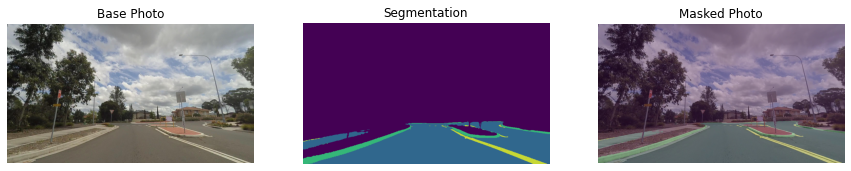

In [43]:
# Define titles with images
data = {"Base Photo": rgb_image, "Segmentation": mask, "Masked Photo": image_with_mask}

# Create subplot to visualize images
f, axs = plt.subplots(1, len(data.items()), figsize=(15, 10))

# Fill subplot
for ax, (name, image) in zip(axs, data.items()):
    ax.axis('off')
    ax.set_title(name)
    ax.imshow(image)

# Display image
plt.show(f)